# Sea Ice Report Card Generator

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import geopandas as gpd
from datetime import datetime

In [2]:
def add_time_dim(xda):
    " Add arbitary time dim for open mf dataset, doesn't matter because we are calculating monthly mean"
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

In [3]:
work_dir = '/g/data/gv90/P6_data/tracker_data/'
#work_dir = 'https://nilas.org/tracker_data/'

## Make changes to dates here

In [4]:
year='2024'
month='2'
includelongtermmean=True

In [16]:
# import urllib.request
# import xarray as xr
# import io

# url = f'{work_dir}/sea_ice_extent_mean/ice_extent_mean_8.json'

# req = urllib.request.Request(url,  headers={'User-Agent': 'Mozilla/5.0'})

# with urllib.request.urlopen(req) as resp:
#     ds = gpd.read_file(io.BytesIO(resp.read()))

## Load Data

In [5]:
extent = gpd.read_file(f'{work_dir}sea_ice_extent_mean/ice_extent_mean_{month}.json')
extent = extent.to_crs("EPSG:3976")
extent = extent.loc[extent['z_value'] == '0.15']

SST_anom = xr.open_dataset(f'{work_dir}sst_anoms_cog/sst_anoms_{year}_{month}.tiff')['band_data'].isel(band=0)
SIC = xr.open_mfdataset(f'{work_dir}sea_ice_conc_6km_cog/asi-AMSR2-s6250-*{year}0{month}*-v5.4.tif', preprocess=add_time_dim)
SIC = SIC['z'].where(SIC['z'] !=0, np.nan).where(SIC['z'] !=120, np.nan).where(SIC['z'] >15, np.nan).isel(band=0).mean(dim='time')
# SIC = xr.open_dataset(f'{work_dir}sea_ice_conc_25km_cog/nsidc_sea_ice_conc_{year}_{month}.tiff')
# SIC = SIC['band_data'].where(SIC['band_data'] !=0, np.nan).where(SIC['band_data'] >15, np.nan).isel(band=0)

## Generate report card

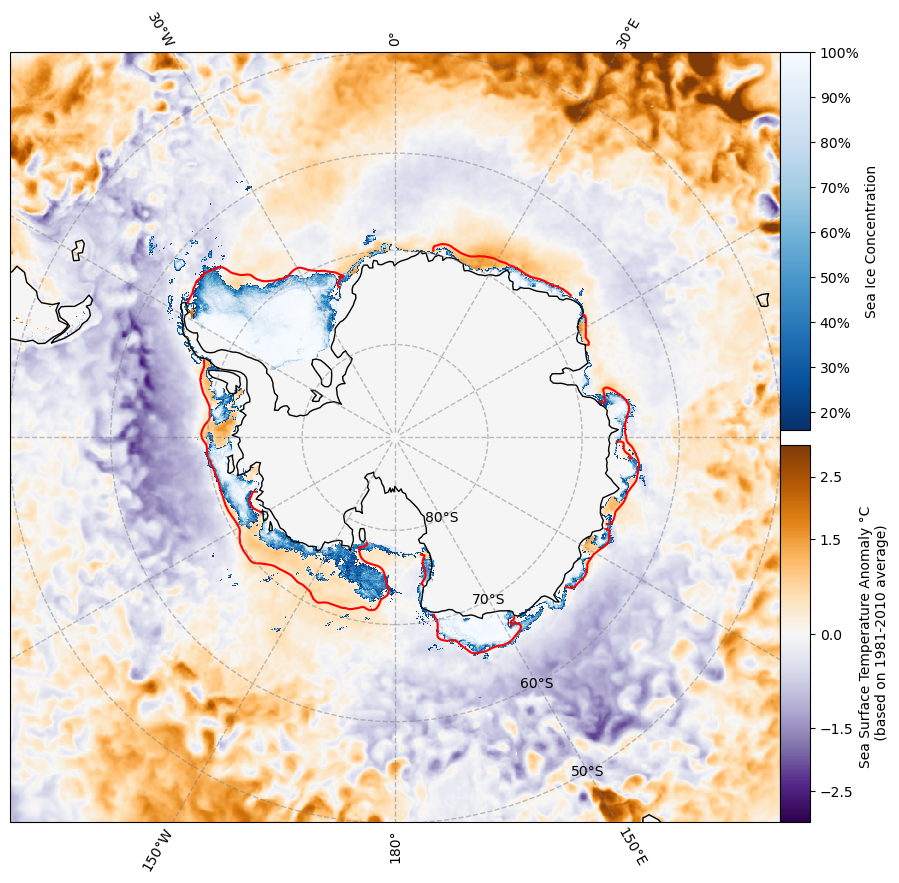

In [6]:
fig = plt.figure(figsize=(10,10))

ax=fig.add_subplot(projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))
ax.set_facecolor('whitesmoke')

SST_PLT = plt.pcolormesh(
    SST_anom.x, 
    SST_anom.y, 
    SST_anom,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    cmap='PuOr_r',
    vmin=-3,
    vmax=3, 
    shading='auto'
)

#sea ice conc anoms
SIC_PLT = plt.pcolormesh(
    SIC.x, 
    SIC.y, 
    SIC,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    cmap='Blues_r', shading='auto'
)

if includelongtermmean == True: 
    extent.plot(color='red',ax=ax)

pos = ax.get_position()
bar_h = (pos.y1 - pos.y0) * 0.49# 0.5 joins the two bars, e.g. 0.48 separates them a bit
ax_cbar1 = fig.add_axes([pos.x1 + 0, pos.y0, 0.03, bar_h])
cbar1 = fig.colorbar(SST_PLT, cax=ax_cbar1, orientation='vertical', label='Sea Surface Temperature Anomaly °C \n (based on 1981-2010 average)')
ax_cbar2 = fig.add_axes([pos.x1 + 0, pos.y1 - bar_h, 0.03, bar_h])
cbar2 = fig.colorbar(SIC_PLT, cax=ax_cbar2, orientation='vertical', format=ticker.PercentFormatter(xmax=100), label='Sea Ice Concentration')

cbar1.set_ticks([-2.5, -1.5, 0, 1.5, 2.5])

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    xlocs=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180], ylocs=[-50,-60,-70,-80]
)

ax.coastlines()
plt.savefig(f'/g/data/gv90/P6_data/report_card/report_card_{year}{month}.png',bbox_inches='tight')
plt.show()

# Different style

In [8]:
import rioxarray

In [17]:
SIC

<xarray.DataArray 'z' (band: 1, y: 1328, x: 1264)>
[1678592 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -3.947e+06 -3.941e+06 ... 3.941e+06 3.947e+06
  * y            (y) float64 4.347e+06 4.341e+06 ... -3.941e+06 -3.947e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_ARTIST:            University of Bremen, Gunnar Spreen [gunnar.sp...
    TIFFTAG_IMAGEDESCRIPTION:  AMSR2 sea ice concentration using the ASI algo...
    TIFFTAG_SOFTWARE:          gdal and GMT
    actual_range:              [  0. 120.]
    long_name:                 z
    _FillValue:                0
    scale_factor:              1.0
    add_offset:                0.0

In [18]:
extent = gpd.read_file(f'{work_dir}sea_ice_extent_mean/ice_extent_mean_{month}.json')
extent = extent.to_crs("EPSG:3976")
extent = extent.loc[extent['z_value'] == '0.15']

SST_anom = xr.open_dataset(f'{work_dir}sst_anoms_cog/sst_anoms_{year}_{month}.tiff')['band_data'].isel(band=0)
SIC = rioxarray.open_rasterio('/g/data/gv90/P6_data/tracker_data/sea_ice_conc_6km_cog/asi-AMSR2-s6250-20240217-v5.4.tif')
# SIC = xr.open_dataset(f'{work_dir}sea_ice_conc_6km_cog/asi-AMSR2-s6250-20240217-v5.4.tif ')
SIC = SIC.where(SIC !=0, np.nan).where(SIC !=120, np.nan).where(SIC >15, np.nan).isel(band=0)#.mean(dim='time')
# SIC = xr.open_dataset(f'{work_dir}sea_ice_conc_25km_cog/nsidc_sea_ice_conc_{year}_{month}.tiff')
# SIC = SIC['band_data'].where(SIC['band_data'] !=0, np.nan).where(SIC['band_data'] >15, np.nan).isel(band=0)

/jobfs/108583906.gadi-pbs/ipykernel_1157539/346869593.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(lines, labels=['Long term February mean (1981-2010)'],loc='upper right')


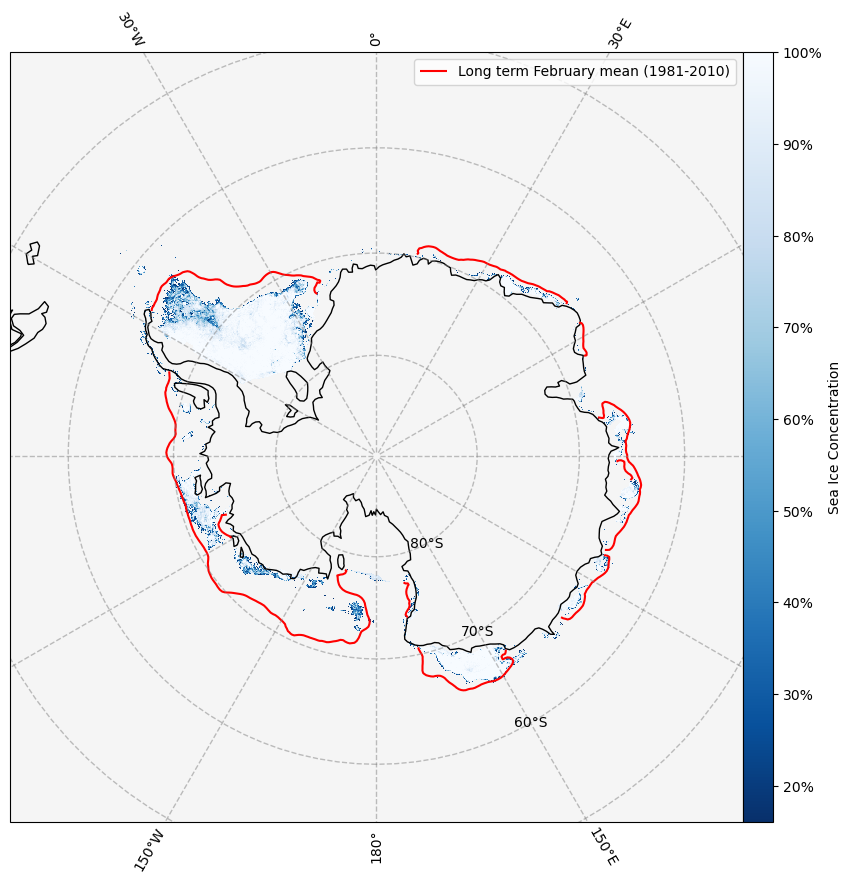

In [24]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(10,10))

ax=fig.add_subplot(projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))
ax.set_facecolor('whitesmoke')

# SST_PLT = plt.pcolormesh(
#     SST_anom.x, 
#     SST_anom.y, 
#     SST_anom,
#     transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
#     cmap='PuOr_r',
#     vmin=-3,
#     vmax=3, 
#     shading='auto'
# )

#sea ice conc anoms
SIC_PLT = plt.pcolormesh(
    SIC.x, 
    SIC.y, 
    SIC,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    cmap='Blues_r', shading='auto'
)

if includelongtermmean == True:
    extent.plot(color='red',ax=ax)
#     leg = ax.get_legend()
# print('legend object type: ' + str(type(leg))) # <class NoneType>
# plt.show()

pos = ax.get_position()
bar_h = (pos.y1 - pos.y0) #* 0.49# 0.5 joins the two bars, e.g. 0.48 separates them a bit
# ax_cbar1 = fig.add_axes([pos.x1 + 0, pos.y0, 0.03, bar_h])
# cbar1 = fig.colorbar(SST_PLT, cax=ax_cbar1, orientation='vertical', label='Sea Surface Temperature Anomaly °C \n (based on 1981-2010 average)')
ax_cbar2 = fig.add_axes([pos.x1 + 0, pos.y1 - bar_h, 0.03, bar_h])
cbar2 = fig.colorbar(SIC_PLT, cax=ax_cbar2, orientation='vertical', format=ticker.PercentFormatter(xmax=100), label='Sea Ice Concentration')

# cbar1.set_ticks([-2.5, -1.5, 0, 1.5, 2.5])

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    xlocs=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180], ylocs=[-50,-60,-70,-80]
)

ax.coastlines()
lines=[Line2D([0], [0], color='r', lw=4)]
ax.legend(lines, labels=['Long term February mean (1981-2010)'],loc='upper right')
plt.savefig(f'/g/data/jk72/sc0554/VIPfigdfeb20.png',bbox_inches='tight')
plt.show()